# Лабораторная работа №1
## Тема: Методы градиентного спуска

In [1]:
import sympy as sp
x, y, z, h = sp.symbols('x y z h')

In [2]:
sp.init_printing()

In [3]:
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)

#### Условие

In [78]:
def f(x):
    y = ((x[0]+7)**2 + 4*(x[1]-3)**2+2*(x[0]+7)*(x[1]-3))**2
#     y = x[0]**2 + 2*x[1]**2 + 0.012*x[0]*x[1] - 2*x[0] + x[1]
#     y = (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2  # rosenbrock
    return y

#### График функции

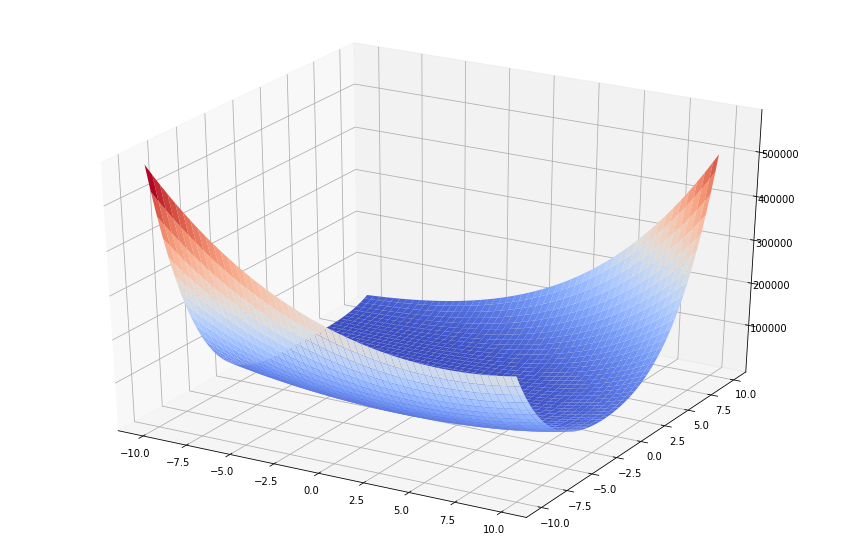

In [79]:
temp = np.arange(-10, 10, 0.1)
a, b = np.meshgrid(temp, temp)
c = f((a, b))

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(a, b, c, cmap=cm.coolwarm)

#### Производные функции

In [80]:
def df(x, h_step=0.01):
    h_matr = h_step * np.eye(x.shape[0])
    y = np.array([(f(x+h) - f(x-h))/(2*h_step) for h in h_matr])
    return y

In [81]:
def d2f(x, h_step=0.01):
    h_matr = h_step * np.eye(x.shape[0])
    y = np.array([(df(x+h, h_step=h_step) - df(x-h, h_step=h_step))/(2*h_step) for h in h_matr])
    return y

In [82]:
a = f(np.array([x, y]))
a

In [83]:
b = df(np.array([x, y]), h_step=h)
sp.Matrix([sp.simplify(item) for item in b])

⎡                                                                2            
⎢  ⎛         2                                                 2⎞    ⎛        
⎢- ⎝4⋅(y - 3)  + (y - 3)⋅(-2.0⋅h + 2⋅x + 14) + (-1.0⋅h + x + 7) ⎠  + ⎝4⋅(y - 3
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                               2⋅h           
⎢                                                                             
⎢                                                               2             
⎢    ⎛       2                                                2⎞    ⎛       2 
⎢  - ⎝(x + 7)  - 2⋅(x + 7)⋅(1.0⋅h - y + 3) + 4⋅(1.0⋅h - y + 3) ⎠  + ⎝(x + 7)  
⎢  ───────────────────────────────────────────────────────────────────────────
⎣                                                               2⋅h           

                                                   2⎤
 2                                               2⎞ ⎥
)  + (y - 3)⋅(2.0⋅h + 

In [84]:
c = d2f(np.array([x, y]), h_step=h)
sp.Matrix([[sp.simplify(item) for item in row]for row in c])

⎡     2         2                             2                           2   
⎢8.0⋅h  + 12.0⋅x  + 24.0⋅x⋅y + 96.0⋅x + 24.0⋅y  + 24.0⋅y + 300.0    20.0⋅h  + 
⎢                                                                             
⎢      2         2                             2                         2    
⎣20.0⋅h  + 12.0⋅x  + 48.0⋅x⋅y + 24.0⋅x + 48.0⋅y  + 48.0⋅y + 12.0  128.0⋅h  + 2

      2                             2                  ⎤
12.0⋅x  + 48.0⋅x⋅y + 24.0⋅x + 48.0⋅y  + 48.0⋅y + 12.0  ⎥
                                                       ⎥
     2                              2                  ⎥
4.0⋅x  + 96.0⋅x⋅y + 48.0⋅x + 192.0⋅y  - 480.0⋅y + 888.0⎦

#### Градиентный спуск

In [85]:
def run(start_data, error=1e-6):
    x_arr = copy(start_data)
    alpha = 0.001
    count = 0
    while True:
        x = x_arr[-1]
        h = df(x)
        x_next = x - alpha * h
        x_arr.append(x_next)
        if np.linalg.norm(x_next - x) < error:
            break
        count += 1
    return x_arr

#### Быстрейший спуск

In [86]:
def run_fastest(start_data, error=1e-6):
    x_arr = copy(start_data)
    count = 0
    while True:
        x = x_arr[-1]
        h = df(x)
        A = d2f(x)
        alpha = (h @ h)/(A @ h @ h)
        x_next = x - alpha * h
        x_arr.append(x_next)
        if np.linalg.norm(x_next - x) < error:
            break
        count += 1
    return x_arr

#### Метод дробления шага

In [87]:
def run_shredded(start_data, error=1e-6):
    x_arr = copy(start_data)
    coef = 0.5
    alpha= 1  # - for rosenbrock
    count = 0
    while True:
        x = x_arr[-1]
        h = df(x)
        while f(x - alpha*h) >= f(x):
            alpha = coef * alpha
        x_next = x - alpha * h
        x_arr.append(x_next)
        if np.linalg.norm(x_next - x) < error:
            break
        count += 1
    return x_arr

#### Овражный спуск с фиксированым шагом

In [89]:
def run_ravine_fixed(start_data, error=1e-6):
    alpha = 1e-3
    t = error
    x_arr = copy(start_data)
    count = 0
    while True:
        x_prev = x_arr[-2]
        x = x_arr[-1]
        v_next = x - (x - x_prev)/np.linalg.norm(x - x_prev)*t*np.sign(f(x) - f(x_prev))
        x_next = v_next - alpha*df(v_next) 
        x_arr.append(x_next)
        if np.linalg.norm(x_next - x) < error:
            break
        count += 1
    return x_arr

#### Овражный спуск

In [90]:
def run_ravine(start_data, error=1e-6):
    t = error
    x_arr = copy(start_data)
    count = 0
    while True:
        x_prev = x_arr[-2]
        x = x_arr[-1]
        v_next = x - (x - x_prev)/np.linalg.norm(x - x_prev)*t*np.sign(f(x) - f(x_prev))
        x_next = v_next - (df(v_next)@df(v_next))/(d2f(v_next)@df(v_next)@df(v_next))*df(v_next) 
        x_arr.append(x_next)
        if np.linalg.norm(x_next - x) < error:
            break
        count += 1
    return x_arr

#### Построение графика

In [91]:
def plot_data(data):
    temp = np.arange(-5.5, 5.5, 0.1)
    a, b = np.meshgrid(temp, temp)
    c = f((a, b))
    plt.contourf(a, b, c)
    plt.grid()
    plt.plot([i[0] for i in data], [i[1] for i in data], linewidth=3, color='red')
    plt.show()

#### Демонстрация

In [92]:
size = 10
start = list([2*size*(np.random.random(2) - 0.5) for i in range(2)])
e = 1e-6

temp = np.arange(-1*size-0.5, size+0.5, 0.1)
a, b = np.meshgrid(temp, temp)
c = f((a, b))

Text(0.5, 1.0, 'Градієнтний спуск (фіксований $\\alpha$) - 6')

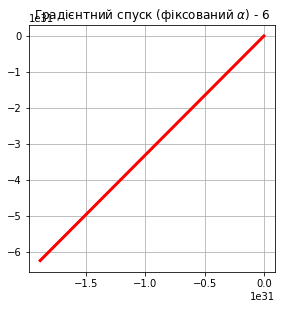

In [93]:
plt.subplot(2, 3, 1)
plt.contourf(a, b, c)
plt.grid()
first = run(start[1:], e)
plt.plot([i[0] for i in first], [i[1] for i in first], linewidth=3, color='red')
plt.gca().set_title(r'Градієнтний спуск (фіксований $\alpha$) - ' + f'{len(first)}')

Text(0.5, 1.0, 'Метод найшвидшого спуску - 62')

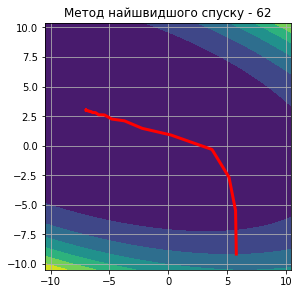

In [94]:
plt.subplot(2, 3, 2)
plt.contourf(a, b, c)
plt.grid()
second = run_fastest(start[1:], e)
plt.plot([i[0] for i in second], [i[1] for i in second], linewidth=3, color='red')
plt.gca().set_title(r'Метод найшвидшого спуску - ' + f'{len(second)}')

In [95]:
second[-1]

array([-6.99998703,  2.99999655])

Text(0.5, 1.0, 'Метод дробленого кроку - 64195')

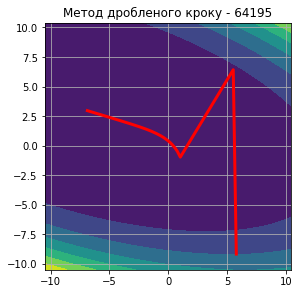

In [96]:
plt.subplot(2, 3, 3)
plt.contourf(a, b, c)
plt.grid()
third = run_shredded(start[1:], e)
plt.plot([i[0] for i in third], [i[1] for i in third], linewidth=3, color='red')
plt.gca().set_title(r'Метод дробленого кроку - ' + f'{len(third)}')

In [97]:
third[-1]

array([-6.87772134,  2.96311002])

[8.4266893  5.38864131]
[ 8.39105957e+00 -9.54920596e+03]
[2.74644971e+01 3.81992746e+07]
[-7.86157355e+04 -1.52758854e+11]


Text(0.5, 1.0, 'Ярний метод (фіксований $\\alpha$) - 7')

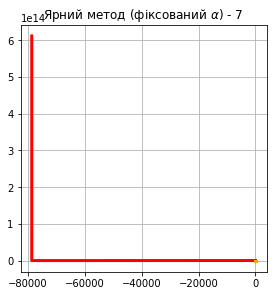

In [69]:
plt.subplot(2, 3, 4)
plt.contourf(a, b, c)
plt.grid()
fourth = run_ravine_fixed(start, e)
plt.plot([i[0] for i in fourth[1:]], [i[1] for i in fourth[1:]], linewidth=3, color='red')
plt.plot([i[0] for i in fourth[:2]], [i[1] for i in fourth[:2]], linewidth=3, color='orange')
plt.gca().set_title(r'Ярний метод (фіксований $\alpha$) - ' + f'{len(fourth)}')

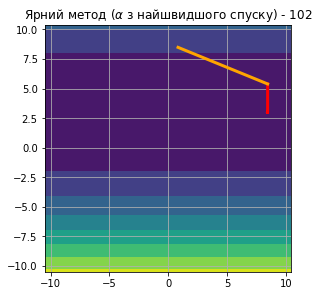

In [67]:
plt.subplot(2, 3, 5)
plt.contourf(a, b, c)
plt.grid()
fifth = run_ravine(start, e)
plt.plot([i[0] for i in fifth[1:]], [i[1] for i in fifth[1:]], linewidth=3, color='red')
plt.plot([i[0] for i in fifth[:2]], [i[1] for i in fifth[:2]], linewidth=3, color='orange')
plt.gca().set_title(r'Ярний метод ($\alpha$ з найшвидшого спуску) - ' + f'{len(fifth)}')

plt.show()

In [ ]:
first[-1]